<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [1]:
from tensorflow import keras 
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn import preprocessing

import numpy as np

In [2]:
train, test = boston_housing.load_data(path='boston_housing.npz', test_split=0.3, seed=47)
X_train = train[0]
y_train = train[1]
X_test = test[0]
y_test = test[1]

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((354, 13), (354,), (152, 13), (152,))

In [4]:
scaler = preprocessing.MinMaxScaler()

In [5]:
X_train = scaler.fit_transform(X_train)

In [6]:
X_test = scaler.fit_transform(X_test)

In [7]:
model = Sequential()
# Input ==> Hidden
model.add(Dense(13, input_dim=13, activation='relu'))
# Hidden
model.add(Dense(13, activation='relu'))
# Output Layer
model.add(Dense(1))

model.compile(loss='mse',
                    optimizer='adam', 
                    metrics=['mse'])
model.summary()

W0912 00:34:14.494269 10316 deprecation.py:506] From C:\Users\nchib\Anaconda3\envs\U4-S2-NN\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                182       
_________________________________________________________________
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 14        
Total params: 378
Trainable params: 378
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_split=.1, verbose=0)
scores = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[1]}: {scores[1]}')

152/152 [==============================] - 0s 33us/sample - loss: 15.4031 - mean_squared_error: 15.4031
mean_squared_error: 15.403149604797363


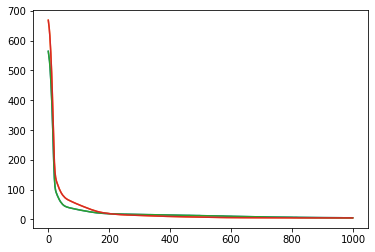

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

29.02025328994949

## Feature Engineering

In [12]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()

In [14]:
import pandas as pd
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [15]:
boston['MEDV'] = boston_dataset.target

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats

In [19]:
train, test = train_test_split(boston, test_size=0.33, random_state=42)

In [20]:
train.shape, test.shape

((339, 14), (167, 14))

In [26]:
def wrangle(X):
    X = X.copy()
    z = np.abs(stats.zscore(X))
    X = X[(z < 3).all(axis=1)]
    
    return X

In [27]:
train = wrangle(train)
test = wrangle(test)

In [30]:
boston.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [31]:
features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'PTRATIO', 'B', 'LSTAT']
target = ['MEDV']

In [32]:
from sklearn.preprocessing import StandardScaler

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Test MSE:', mean_squared_error(y_test, y_pred))

Test MSE: 11.128720459573902


## Wrangled data set with Keras

In [39]:
model = Sequential()
# Input ==> Hidden
model.add(Dense(13, input_dim=12, activation='relu'))
# Hidden
model.add(Dense(13, activation='relu'))
# Output Layer
model.add(Dense(1))

model.compile(loss='mse',
                    optimizer='adam', 
                    metrics=['mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 13)                169       
_________________________________________________________________
dense_10 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 14        
Total params: 365
Trainable params: 365
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_split=.1, verbose=0)
scores = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[1]}: {scores[1]}')

131/131 [==============================] - 0s 31us/sample - loss: 9.7651 - mean_squared_error: 9.7651
mean_squared_error: 9.76507568359375


## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [41]:
import tensorflow
from tensorflow import keras 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import numpy as np

In [42]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [43]:
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

X_train shape: (60000, 28, 28) y_train shape: (60000,)


In [44]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [45]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [46]:
batch_size = 64
num_class = 10
epochs = 20

In [47]:
y_train = tensorflow.keras.utils.to_categorical(y_train, num_class)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_class)

In [48]:
y_train[2]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [49]:
X_train /= 255
X_test /= 255
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [76]:
mnist_model = Sequential()
mnist_model.add(Dense(16, input_dim=784, activation='relu', name='input_layer'))
mnist_model.add(Dense(16, activation='relu', name="hidden_layer"))
mnist_model.add(Dense(10,activation='softmax',name="output_layer"))
mnist_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
mnist_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 16)                12560     
_________________________________________________________________
hidden_layer (Dense)         (None, 16)                272       
_________________________________________________________________
output_layer (Dense)         (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = mnist_model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=.15, verbose=0)
scores = mnist_model.evaluate(X_test, y_test)
print(f'{mnist_model.metrics_names[1]}: {scores[1]*100}')

In [67]:
input_shape= X_train[0].shape

In [59]:
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

C:\Users\nchib\Anaconda3\envs\U4-S2-NN\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [60]:
dim_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_input_nodes = Integer(low=1, high=512, name='num_input_nodes')
dim_num_dense_nodes = Integer(low=1, high=28, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid'],
                             name='activation')
dim_batch_size = Integer(low=1, high=128, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              dim_adam_decay
             ]
default_parameters = [1e-3, 1,512, 13, 'relu',64, 1e-3]

In [62]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow
from tensorflow.python.keras import backend as K

Using TensorFlow backend.


In [63]:
from keras.optimizers import Adam
def create_model(learning_rate, num_dense_layers,num_input_nodes,
                 num_dense_nodes, activation, adam_decay):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape= input_shape, activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(10,activation='softmax'))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [64]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_input_nodes, 
            num_dense_nodes,activation, batch_size,adam_decay):

    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_input_nodes=num_input_nodes,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         adam_decay=adam_decay
                        )
    

    #named blackbox becuase it represents the structure
    blackbox = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=batch_size,
                        validation_split=0.15,
                        )
    #return the validation accuracy for the last epoch.
    accuracy = blackbox.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tensorflow.reset_default_graph()
    
    return -accuracy

In [65]:
K.clear_session()
tensorflow.reset_default_graph()

In [ ]:
gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=12,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=default_parameters)

In [69]:
print("best accuracy was " + str(round(gp_result.fun *-100,2))+"%.")

best accuracy was 89.42%.


In [70]:
gp_result.x

[0.00020355247427124, 5, 259, 26, 'relu', 124, 0.0023861427015795782]

In [71]:
gp_result.func_vals

array([-0.87655556, -0.8831111 , -0.88888889, -0.89144445, -0.89288889,
       -0.892     , -0.89422222, -0.89277777, -0.89266667, -0.89322223,
       -0.89333333, -0.8921111 ])

In [72]:
pd.concat([pd.DataFrame(gp_result.x_iters, columns = ["learning rate","hidden layers","input layer nodes","hidden layer nodes",
                                           "activation function","batch size","adam learning rate decay"]),
(pd.Series(gp_result.func_vals*-100, name="accuracy"))], axis=1)

,learning rate,hidden layers,input layer nodes,hidden layer nodes,activation function,batch size,adam learning rate decay,accuracy
0,0.001000,1,512,13,relu,64,0.001000,87.655556
1,0.009031,4,35,20,relu,90,0.002593,88.311110
2,0.000620,3,13,20,relu,107,0.009111,88.888889
3,0.009706,2,424,28,sigmoid,9,0.004085,89.144445
4,0.003193,1,34,27,relu,88,0.005207,89.288889
5,0.000104,4,301,15,relu,118,0.000516,89.200000
6,0.000204,5,259,26,relu,124,0.002386,89.422222
7,0.002680,1,28,3,relu,26,0.002163,89.277777
8,0.002563,3,449,17,relu,116,0.005452,89.266667
9,0.000124,3,75,5,sigmoid,113,0.002328,89.322223


In [74]:
gp_model = create_model(gp_result.x[0],gp_result.x[1],gp_result.x[2],gp_result.x[3],gp_result.x[4],gp_result.x[5])
gp_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 259)               203315    
_________________________________________________________________
layer_dense_1 (Dense)        (None, 26)                6760      
_________________________________________________________________
layer_dense_2 (Dense)        (None, 26)                702       
_________________________________________________________________
layer_dense_3 (Dense)        (None, 26)                702       
_________________________________________________________________
layer_dense_4 (Dense)        (None, 26)                702       
_________________________________________________________________
layer_dense_5 (Dense)        (None, 26)                702       
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [90]:
gp_model.fit(X_train,y_train, epochs=3)
gp_model.evaluate(X_test,y_test)

Epoch 1/3
60000/60000 [==============================] - 16s 269us/step - loss: 0.2023 - acc: 0.9289
Epoch 2/3
60000/60000 [==============================] - 16s 269us/step - loss: 0.2014 - acc: 0.9290
Epoch 3/3
10000/10000 [==============================] - 0s 50us/step


[0.3079898268163204, 0.89]

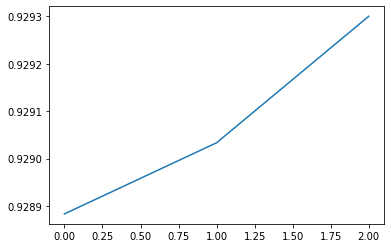

In [94]:
plt.plot(gp_model.history.history['acc'])
plt.show()

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.

In [96]:
K.clear_session()
tensorflow.reset_default_graph()

In [100]:
import tensorflow
from tensorflow import keras 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import numpy as np

In [101]:
mnist_model = Sequential()
mnist_model.add(Dense(16, input_dim=784, activation='relu', name='input_layer'))
mnist_model.add(Dense(16, activation='relu', name="hidden_layer"))
mnist_model.add(Dense(10,activation='softmax',name="output_layer"))
mnist_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
mnist_model.summary()

history = mnist_model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=.15, verbose=0)
scores = mnist_model.evaluate(X_test, y_test)
print(f'{mnist_model.metrics_names[1]}: {scores[1]*100}')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 16)                12560     
_________________________________________________________________
hidden_layer (Dense)         (None, 16)                272       
_________________________________________________________________
output_layer (Dense)         (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________
10000/10000 [==============================] - 0s 19us/sample - loss: 0.4008 - acc: 0.8596
acc: 85.96000075340271


In [113]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import random

In [125]:
# Create model for KerasClassifier
def create_model(num_dense_layers=1,
                 num_input_nodes=512,
                 num_dense_nodes=13,
                 activation='relu',
                 batch_size=64,
                 epochs=3):
    #start the model making process and create our first layer
    mmodel = Sequential()
    mmodel.add(Dense(num_input_nodes, input_dim=784, activation=activation, name='input_layer'))
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        mmodel.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    mmodel.add(Dense(10, activation='softmax',name="output_layer"))
    mmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
    return mmodel


model = KerasClassifier(build_fn=create_model) 

# Specify parameters and distributions to sample from

num_dense_layers = [1,2,3,4,5]
num_input_nodes = [1,50,100,150,200]
num_dense_nodes = [1,20,50,70,100]
activation = ['relu', 'sigmoid']
batch_size = [1,50,100,150,200]
epochs = [3,20,100]

# Prepare the Dict for the Search
param_dist = dict(num_dense_layers=num_dense_layers,
                  num_input_nodes=num_input_nodes,
                  num_dense_nodes=num_dense_nodes,
                  activation=activation,
                  batch_size=batch_size,
                  epochs=epochs)

# Search in action!
n_iter_search = 16 # Number of parameter settings that are sampled.
random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   n_jobs=-1, cv=5, verbose=2)

random_search.fit(X_train, y_train)

# Show the results
print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 45.3min finished


Epoch 1/20
60000/60000 [==============================] - 2s 30us/sample - loss: 0.9782 - acc: 0.6718
Epoch 2/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.4541 - acc: 0.8388
Epoch 3/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.3894 - acc: 0.8604
Epoch 4/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.3567 - acc: 0.8719
Epoch 5/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.3377 - acc: 0.8788
Epoch 6/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.3204 - acc: 0.8842
Epoch 7/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.3064 - acc: 0.8895
Epoch 8/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.2952 - acc: 0.8925
Epoch 9/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.2840 - acc: 0.8973
Epoch 10/20
60000/60000 [==============================] - 2s 26us/sample - loss: 